# Intro to Cython and Numba

# Why Cython

![DevTime](whycython.png)

Outline:

* Cython
* Numba


# Part 1: cython

We want to integrate the function $f(x) = x^4 - 3x$.

In [141]:
def f(x):
    y = x**4 - 3*x
    return y
    
def integrate_f(a, b, n):
    dx = (b - a) / n
    dx2 = dx / 2
    s = f(a) * dx2
    for i in range(1, n):
        s += f(a + i * dx) * dx
    s += f(b) * dx2
    return s

integrate_f(-100, 100, int(1e5))

4000000002.666731

Now, let's time this:

In [142]:
%timeit integrate_f(-100, 100, int(1e5))

32.7 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not too bad, but this can add up. Let's see if Cython can do better:

In [143]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [144]:
%%cython

def f2(x):
    y = x**4 - 3*x
    return y
    
def integrate_f2(a, b, n):
    dx = (b - a) / n
    dx2 = dx / 2
    s = f2(a) * dx2
    for i in range(1, n):
        s += f2(a + i * dx) * dx
    s += f2(b) * dx2
    return s

In [148]:
f2

'_cython_magic_07a2e1ae1f811f804e4c989217ca4592'

In [150]:
import sys
sys.modules[f2.__module__]

<module '_cython_magic_07a2e1ae1f811f804e4c989217ca4592' (/home/zbyszek/.cache/ipython/cython/_cython_magic_07a2e1ae1f811f804e4c989217ca4592.cpython-36m-x86_64-linux-gnu.so)>

In [151]:
integrate_f2(-100, 100, int(1e5))

4000000002.666731

In [152]:
%timeit integrate_f2(-100, 100, int(1e5))

23.4 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's a little bit faster, which is nice since all we did was to call Cython on the exact same code. But can we do better?

### manual type specialization

In [153]:
%%cython

def f3(double x):
    y = x**4 - 3*x
    return y
    
def integrate_f3(double a, double b, int n):
    dx = (b - a) / n
    dx2 = dx / 2
    s = f3(a) * dx2
    for i in range(1, n):
        s += f3(a + i * dx) * dx
    s += f3(b) * dx2
    return s

In [154]:
%timeit integrate_f3(-100, 100, int(1e5))

17.8 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The final bit of "easy" Cython optimization is "declaring" the variables inside the function:

In [155]:
%%cython

def f4(double x):
    y = x**4 - 3*x
    return y
    
def integrate_f4(double a, double b, int n):
    cdef:
        double dx = (b - a) / n
        double dx2 = dx / 2
        double s = f4(a) * dx2
        int i
    for i in range(1, n):
        s += f4(a + i * dx) * dx
    s += f4(b) * dx2
    return s

In [156]:
%timeit integrate_f4(-100, 100, int(1e5))

13.2 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3× speedup with so little effort is pretty nice. What else can we do?

Cython has a nice "-a" flag (for annotation) that can provide clues about why your code is slow.

In [157]:
%%cython -a

def f4(double x):
    y = x**4 - 3*x
    return y
    
def integrate_f4(double a, double b, int n):
    cdef:
        double dx = (b - a) / n
        double dx2 = dx / 2
        double s = f4(a) * dx2
        int i = 0
    for i in range(1, n):
        s += f4(a + i * dx) * dx
    s += f4(b) * dx2
    return s

That's a lot of yellow still! How do we reduce this?

### function specialization

In [164]:
%%cython -a
cimport cython

cdef f5(double x):
    y = x**4 - 3*x
    return y

def integrate_f5(double a, double b, int n):
    cdef:
        double dx = (b - a) / n
        double dx2 = dx / 2
        double s = f5(a) * dx2
        int i = 0
    for i in range(1, n):
        s += f5(a + i * dx) * dx
    s += f5(b) * dx2
    return s

In [ ]:
%timeit integrate_f5(-100, 100, 10**5)

### summary of python vs. cython

```
  pure python:                 33 ms
  python-compatible cython:    24 ms 
  specialization of arguments: 18 ms
  full type specilization:     13 ms
  c-only function:             11 ms
  simplified expression form:   3.5 ms
```

![cython architecture](/home/zbyszek/pythonschool/PythonOptimization/cython_architecture.png)

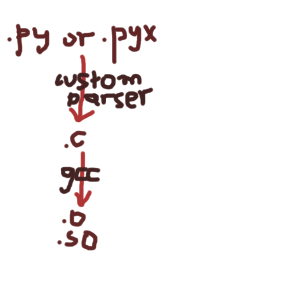

In [178]:
from IPython.display import Image
Image("/home/zbyszek/pythonschool/PythonOptimization/cython_architecture.png", width=500)

# Part 2: numba

In [168]:
from numba import jit

def f(x):
    y = x**4 - 3*x
    return y
    
@jit
def integrate_f6(a, b, n):
    dx = (b - a) / n
    dx2 = dx / 2
    s = f(a) * dx2
    for i in range(1, n):
        s += f(a + i * dx) * dx
    s += f(b) * dx2
    return s

integrate_f6(-100, 100, 10**5) 

4000000002.6667314

In [169]:
%timeit integrate_f6(-100, 100, 10**5) 

163 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


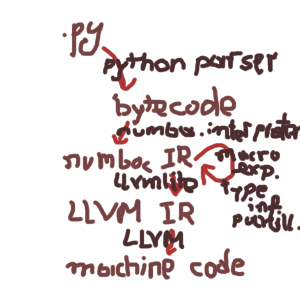

In [174]:
from IPython.display import Image
Image("/home/zbyszek/pythonschool/PythonOptimization/numba_architecture.png", width=500)

#### numpy and C

In [176]:
import numpy as np
def f(x):
    y = x**4 - 3*x
    return y

def integrate_f7(a, b, n):   
    dx = (b - a) / n
    dx2  = dx / 2
    x = np.linspace(a, b, n)
    s = f(x)
    s = s[0]*dx2 + s[1:-1].sum()*dx + s[-1]*dx2 
    return s

integrate_f7(-100, 100, 10**5)

3999960002.6666923

In [177]:
%timeit integrate_f7(-100, 100, 10**5)

6.86 ms ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
### summary of python vs. cython vs. numba vs. C

pure python:                  33 ms
python-compatible cython:     24 ms 
specialization of arguments:  18 ms
full type specilization:      13 ms
c-only function:              11 ms
simplified expression form:    3.5 ms

numba jit:                     0.170 ms
numpy:                         7 ms
numpy simplified expression:   0.500 ms
    
plain C (-O0):                 7.3 ms
C simplified expression (-O0): 1.5 ms
C simplified expression (-O3): 0.165 ms

# Part 3: numba nopython and python modes

In [188]:
@jit
def f(x):
    y = x*5 + x
    return y

In [189]:
f(1)

6

In [190]:
f(np.eye(3))

array([[6., 0., 0.],
       [0., 6., 0.],
       [0., 0., 6.]])

In [191]:
f('abc')

'abcabcabcabcabcabc'

In [192]:
f.signatures

[(int64,), (array(float64, 2d, C),), (str,)]

In [193]:
f.nopython_signatures

[(int64,) -> int64, (array(float64, 2d, C),) -> array(float64, 2d, C)]

In [ ]:
import numba

@numba.jit(numba.types.int32(numba.types.int32))
def f(x):
    y = x**4 - 3*x
    return y

In [ ]:
f(33)

In [ ]:
f(33.5)

In [ ]:
f(np.eye(3))

### automatic parallelization in numba

In [201]:
def trig_ident_np(x):
    return (np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2).sum()/4

@jit
def trig_ident_jit(x):
    s = 0    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            s += (np.sin(x[i,j])**2 + np.cos(x[i,j])**2 +
                  np.sin(x[i,j])**2 + np.cos(x[i,j])**2 +
                  np.sin(x[i,j])**2 + np.cos(x[i,j])**2 +
                  np.sin(x[i,j])**2 + np.cos(x[i,j])**2) / 4
    return s

@jit(parallel=True)
def trig_ident_jitp(x):
    return (np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2 +
            np.sin(x)**2 + np.cos(x)**2).sum()/4


In [195]:
x = np.random.randn(5,5)
x

array([[ 0.37362922, -0.60679012, -2.05663918, -0.28438076,  0.38219053],
       [ 0.24262168,  0.92722849, -0.49633571, -0.59956265,  2.61953562],
       [ 0.64587818, -0.01163814,  0.90323047,  0.18102102,  0.39524354],
       [-0.31200326, -2.01020008, -0.20899278, -0.4557613 ,  1.40160337],
       [-1.27747534, -1.65707897, -1.73121672, -0.99940911, -0.41863538]])

In [205]:
trig_ident_np(x)

25000000.0

In [197]:
x = np.random.randn(500,50000)

In [202]:
%timeit trig_ident_np(x)

1.05 s ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [203]:
%timeit trig_ident_jit(x)

917 ms ± 9.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [204]:
%timeit trig_ident_jitp(x)

384 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Concluding remarks

Some pros and cons about Cython and Numba:

- Cython pros:
  * very wide support
  * easy to distribute compiled code to most users
  * quite developed optimizing workflow (i.e. cython -a)
- Cython cons:
  * need to use a new language


- Numba pros:
  * quite easy to use, especially if you're starting from Cython code
  * often eye-popping, face-melting performance
- Numba cons:
  * hard to install outside of conda
  * hard to optimise. If it's slow, you have to guess (though they are helpful on mailing list)
  * many parts of Python still unsupported, e.g. dicts.
  * project still young and some people are paranoid that it could disappear